# Preliminary NAS Analysis: 12 Pure Trials

## Context

**Goal**: Run 100 trials with 150 generations, 500 population, 3 seeds

**What happened**: Parallel execution (`n_jobs=5`) failed at production scale - ran sequentially instead

**Result**: Only 12 trials completed in 8 hours (should have been ~210 trials)

**This notebook**: Analyzes what we learned from those 12 trials

---

## Key Findings Preview

Despite the failed run, these 12 trials provide:
- Fitness range validation (best trial: 522.8)
- Parameter sensitivity insights
- Proof that the pipeline works end-to-end
- Baseline for future searches

In [6]:
# !pip install pandas
# !pip install seaborn

In [7]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Trial Data

In [8]:
# Load all trial files
results_dir = Path('results/search_pure-production-150gen_20260130_091027')
trial_files = sorted(results_dir.glob('trial_*.json'))

print(f"Found {len(trial_files)} trial files")

trials = []
for trial_file in trial_files:
    with open(trial_file) as f:
        trials.append(json.load(f))

print(f"Loaded {len(trials)} trials")
print(f"\nTrial numbers: {sorted([t['trial_number'] for t in trials])}")

Found 12 trial files
Loaded 12 trials

Trial numbers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]


## 2. Create Analysis DataFrame

In [9]:
# Extract data into structured format
data = []
for trial in trials:
    row = {
        'trial_number': trial['trial_number'],
        'mean_best_fitness': trial['mean_best_fitness'],
        'mean_avg_fitness': trial['mean_avg_fitness'],
        'best_fitness_std': np.std(trial['best_fitness_per_seed']),
        'best_fitness_max': max(trial['best_fitness_per_seed']),
        'best_fitness_min': min(trial['best_fitness_per_seed']),
    }
    # Add all parameters
    row.update(trial['params'])
    data.append(row)

df = pd.DataFrame(data)
df = df.sort_values('mean_best_fitness', ascending=False)

print(f"DataFrame shape: {df.shape}")
print(f"\nParameters explored: {len(df.columns) - 6}")

DataFrame shape: (12, 23)

Parameters explored: 17


## 3. Summary Statistics

In [10]:
print("=" * 60)
print("FITNESS SUMMARY")
print("=" * 60)
print(f"\nBest trial fitness: {df['mean_best_fitness'].max():.1f}")
print(f"Worst trial fitness: {df['mean_best_fitness'].min():.1f}")
print(f"Mean trial fitness: {df['mean_best_fitness'].mean():.1f}")
print(f"Median trial fitness: {df['mean_best_fitness'].median():.1f}")
print(f"Std dev: {df['mean_best_fitness'].std():.1f}")

print(f"\n{'='*60}")
print("CROSS-SEED VARIANCE")
print("="*60)
print(f"\nMean std across seeds: {df['best_fitness_std'].mean():.1f}")
print(f"Max std across seeds: {df['best_fitness_std'].max():.1f}")
print(f"\nTrials with high variance (std > 100):")
high_var = df[df['best_fitness_std'] > 100][['trial_number', 'mean_best_fitness', 'best_fitness_std']]
print(high_var.to_string(index=False))

FITNESS SUMMARY

Best trial fitness: 522.8
Worst trial fitness: 118.4
Mean trial fitness: 268.0
Median trial fitness: 240.9
Std dev: 134.5

CROSS-SEED VARIANCE

Mean std across seeds: 80.0
Max std across seeds: 194.1

Trials with high variance (std > 100):
 trial_number  mean_best_fitness  best_fitness_std
            4         522.836650        123.527053
            0         407.789429        182.282648
           10         393.948069        119.546630
            3         331.771077        194.057049
           12         124.135648        120.565408


## 4. Top 5 Configurations

In [11]:
print("=" * 60)
print("TOP 5 TRIALS")
print("=" * 60)

top5 = df.head(5)

for idx, row in top5.iterrows():
    print(f"\n{'='*60}")
    print(f"Trial {int(row['trial_number'])} - Fitness: {row['mean_best_fitness']:.1f}")
    print(f"{'='*60}")
    print(f"  Std across seeds: {row['best_fitness_std']:.1f}")
    print(f"  Range: [{row['best_fitness_min']:.1f}, {row['best_fitness_max']:.1f}]")
    print(f"\n  Key parameters:")
    print(f"    Neural hidden size: {int(row['neural_hidden_size'])}")
    print(f"    Selection: {row['selection_method']}")
    print(f"    Crossover: {row['use_crossover']}")
    print(f"    Proprioception: {row['use_proprioception']}")
    print(f"    Mutation rate: {row['mutation_rate']:.3f}")
    print(f"    Weight mutation rate: {row['weight_mutation_rate']:.3f}")
    print(f"    Cull percentage: {row['cull_percentage']:.3f}")
    print(f"    Max muscles: {int(row['max_muscles'])}")
    print(f"    Max nodes: {int(row['max_nodes'])}")

TOP 5 TRIALS

Trial 4 - Fitness: 522.8
  Std across seeds: 123.5
  Range: [348.1, 611.4]

  Key parameters:
    Neural hidden size: 16
    Selection: truncation
    Crossover: False
    Proprioception: False
    Mutation rate: 0.533
    Weight mutation rate: 0.275
    Cull percentage: 0.478
    Max muscles: 18
    Max nodes: 9

Trial 0 - Fitness: 407.8
  Std across seeds: 182.3
  Range: [150.0, 538.9]

  Key parameters:
    Neural hidden size: 16
    Selection: truncation
    Crossover: False
    Proprioception: False
    Mutation rate: 0.375
    Weight mutation rate: 0.166
    Cull percentage: 0.699
    Max muscles: 10
    Max nodes: 11

Trial 10 - Fitness: 393.9
  Std across seeds: 119.5
  Range: [295.0, 562.1]

  Key parameters:
    Neural hidden size: 4
    Selection: rank
    Crossover: False
    Proprioception: False
    Mutation rate: 0.576
    Weight mutation rate: 0.428
    Cull percentage: 0.654
    Max muscles: 17
    Max nodes: 10

Trial 8 - Fitness: 360.4
  Std across seed

## 5. Parameter Distributions

In [12]:
# Analyze categorical parameters
print("=" * 60)
print("CATEGORICAL PARAMETER FREQUENCIES")
print("=" * 60)

categorical_params = ['selection_method', 'use_crossover', 'use_proprioception', 'neural_hidden_size']

for param in categorical_params:
    if param in df.columns:
        print(f"\n{param}:")
        counts = df[param].value_counts()
        for val, count in counts.items():
            print(f"  {val}: {count} trials")

CATEGORICAL PARAMETER FREQUENCIES

selection_method:
  rank: 5 trials
  truncation: 4 trials
  tournament: 3 trials

use_crossover:
  False: 8 trials
  True: 4 trials

use_proprioception:
  False: 8 trials
  True: 4 trials

neural_hidden_size:
  16: 4 trials
  8: 4 trials
  24: 2 trials
  4: 1 trials
  20: 1 trials


## 6. Fitness Distribution Visualization

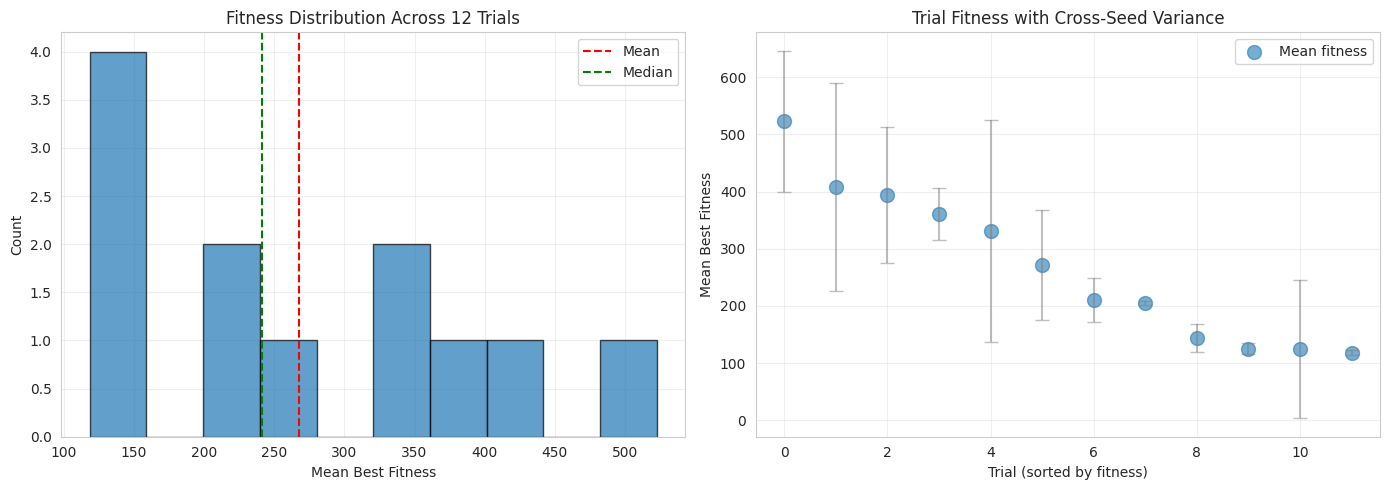

Saved: results/prelim_fitness_distribution.png


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['mean_best_fitness'], bins=10, edgecolor='black', alpha=0.7)
axes[0].axvline(df['mean_best_fitness'].mean(), color='red', linestyle='--', label='Mean')
axes[0].axvline(df['mean_best_fitness'].median(), color='green', linestyle='--', label='Median')
axes[0].set_xlabel('Mean Best Fitness')
axes[0].set_ylabel('Count')
axes[0].set_title('Fitness Distribution Across 12 Trials')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot with variance
axes[1].scatter(range(len(df)), df['mean_best_fitness'], s=100, alpha=0.6, label='Mean fitness')
axes[1].errorbar(range(len(df)), df['mean_best_fitness'], 
                yerr=df['best_fitness_std'], fmt='none', ecolor='gray', alpha=0.5, capsize=5)
axes[1].set_xlabel('Trial (sorted by fitness)')
axes[1].set_ylabel('Mean Best Fitness')
axes[1].set_title('Trial Fitness with Cross-Seed Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/prelim_fitness_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Saved: results/prelim_fitness_distribution.png")

## 7. Parameter Correlation with Fitness

PARAMETER CORRELATIONS WITH FITNESS
(Limited data - only 12 trials, interpret with caution)

                parameter  correlation
       mutation_magnitude     0.503597
            mutation_rate     0.496363
       neural_output_bias     0.454173
     weight_mutation_rate    -0.410927
weight_mutation_magnitude    -0.405031
              max_muscles     0.371899
          cull_percentage     0.345451
                max_nodes     0.332990
         neural_dead_zone     0.315208
                min_nodes     0.220314
       neural_hidden_size     0.014248


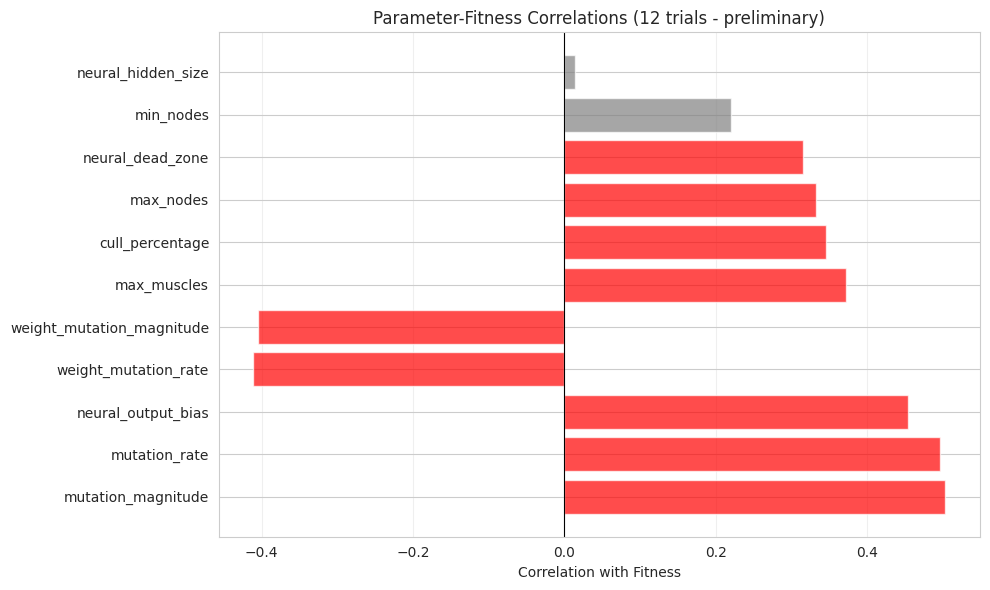


Saved: results/prelim_parameter_correlations.png


In [14]:
# Calculate correlations for continuous parameters
continuous_params = [
    'neural_hidden_size', 'weight_mutation_rate', 'weight_mutation_magnitude',
    'mutation_rate', 'mutation_magnitude', 'cull_percentage',
    'neural_dead_zone', 'neural_output_bias', 'max_muscles', 'max_nodes', 'min_nodes'
]

available_params = [p for p in continuous_params if p in df.columns]

correlations = []
for param in available_params:
    corr = df[param].corr(df['mean_best_fitness'])
    correlations.append({'parameter': param, 'correlation': corr})

corr_df = pd.DataFrame(correlations).sort_values('correlation', key=abs, ascending=False)

print("=" * 60)
print("PARAMETER CORRELATIONS WITH FITNESS")
print("(Limited data - only 12 trials, interpret with caution)")
print("=" * 60)
print("\n" + corr_df.to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red' if abs(c) > 0.3 else 'gray' for c in corr_df['correlation']]
ax.barh(corr_df['parameter'], corr_df['correlation'], color=colors, alpha=0.7)
ax.axvline(0, color='black', linewidth=0.8)
ax.set_xlabel('Correlation with Fitness')
ax.set_title('Parameter-Fitness Correlations (12 trials - preliminary)')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('results/prelim_parameter_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSaved: results/prelim_parameter_correlations.png")

## 8. Selection Method Analysis

SELECTION METHOD COMPARISON

                        mean         std  count
selection_method                               
rank              251.867850  118.768770      5
tournament        203.343650  136.030617      3
truncation        336.613968  155.869096      4


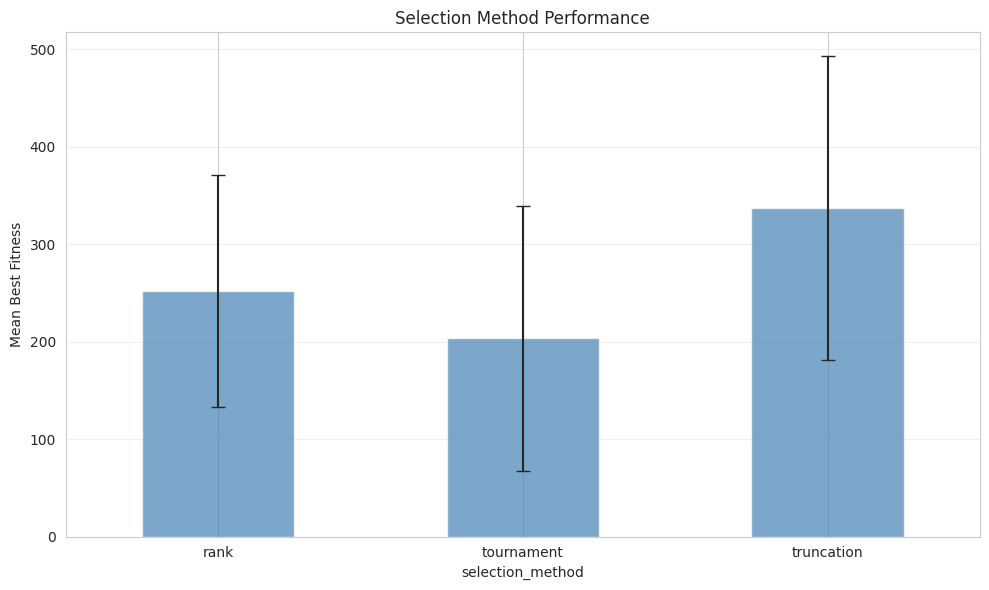


Saved: results/prelim_selection_comparison.png


In [15]:
if 'selection_method' in df.columns:
    selection_fitness = df.groupby('selection_method')['mean_best_fitness'].agg(['mean', 'std', 'count'])
    
    print("=" * 60)
    print("SELECTION METHOD COMPARISON")
    print("=" * 60)
    print("\n" + selection_fitness.to_string())
    
    if len(selection_fitness) > 1:
        fig, ax = plt.subplots(figsize=(10, 6))
        selection_fitness['mean'].plot(kind='bar', ax=ax, yerr=selection_fitness['std'], 
                                       capsize=5, alpha=0.7, color='steelblue')
        ax.set_ylabel('Mean Best Fitness')
        ax.set_title('Selection Method Performance')
        ax.grid(True, alpha=0.3, axis='y')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.savefig('results/prelim_selection_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\nSaved: results/prelim_selection_comparison.png")

## 9. Crossover Effect

In [16]:
if 'use_crossover' in df.columns:
    crossover_fitness = df.groupby('use_crossover')['mean_best_fitness'].agg(['mean', 'std', 'count'])
    
    print("=" * 60)
    print("CROSSOVER EFFECT")
    print("=" * 60)
    print("\n" + crossover_fitness.to_string())
    
    if len(crossover_fitness) > 1:
        diff = crossover_fitness.loc[True, 'mean'] - crossover_fitness.loc[False, 'mean']
        print(f"\nCrossover ON vs OFF: {diff:+.1f} fitness difference")

CROSSOVER EFFECT

                     mean         std  count
use_crossover                               
False          304.359982  140.268241      8
True           195.236553   99.182682      4

Crossover ON vs OFF: -109.1 fitness difference


## 10. Proprioception Effect

In [17]:
if 'use_proprioception' in df.columns:
    proprio_fitness = df.groupby('use_proprioception')['mean_best_fitness'].agg(['mean', 'std', 'count'])
    
    print("=" * 60)
    print("PROPRIOCEPTION EFFECT")
    print("=" * 60)
    print("\n" + proprio_fitness.to_string())
    
    if len(proprio_fitness) > 1:
        diff = proprio_fitness.loc[True, 'mean'] - proprio_fitness.loc[False, 'mean']
        print(f"\nProprioception ON vs OFF: {diff:+.1f} fitness difference")

PROPRIOCEPTION EFFECT

                          mean         std  count
use_proprioception                               
False               263.553208  156.209102      8
True                276.850101   96.110803      4

Proprioception ON vs OFF: +13.3 fitness difference


## 11. Best Configuration Deep Dive

In [18]:
best_trial = df.iloc[0]

print("=" * 60)
print(f"BEST TRIAL: #{int(best_trial['trial_number'])}")
print(f"Fitness: {best_trial['mean_best_fitness']:.1f}")
print("=" * 60)

print("\nFull Configuration:")
print("-" * 60)
for col in df.columns:
    if col not in ['trial_number', 'mean_best_fitness', 'mean_avg_fitness', 
                   'best_fitness_std', 'best_fitness_max', 'best_fitness_min']:
        val = best_trial[col]
        if isinstance(val, float):
            print(f"  {col}: {val:.4f}")
        else:
            print(f"  {col}: {val}")

print("\n" + "="*60)
print("Cross-seed performance:")
print("="*60)
best_trial_data = [t for t in trials if t['trial_number'] == int(best_trial['trial_number'])][0]
for i, (seed, fitness) in enumerate(zip(best_trial_data['seeds'], best_trial_data['best_fitness_per_seed'])):
    print(f"  Seed {seed}: {fitness:.1f}")
print(f"\nMean: {best_trial['mean_best_fitness']:.1f}")
print(f"Std: {best_trial['best_fitness_std']:.1f}")

BEST TRIAL: #4
Fitness: 522.8

Full Configuration:
------------------------------------------------------------
  neural_hidden_size: 16
  weight_mutation_rate: 0.2751
  weight_mutation_magnitude: 0.1001
  mutation_rate: 0.5327
  mutation_magnitude: 0.3434
  cull_percentage: 0.4781
  selection_method: truncation
  use_crossover: False
  use_proprioception: False
  min_nodes: 4
  max_nodes: 9
  max_muscles: 18
  neural_dead_zone: 0.0612
  neural_output_bias: -0.2401
  tournament_size: nan
  crossover_rate: nan
  proprioception_inputs: nan

Cross-seed performance:
  Seed 42: 348.1
  Seed 123: 611.4
  Seed 456: 609.0

Mean: 522.8
Std: 123.5


## 12. Key Insights & Recommendations

In [19]:
print("=" * 70)
print("KEY INSIGHTS FROM 12 TRIALS")
print("=" * 70)

print("\n1. FITNESS RANGE")
print(f"   - Best achieved: {df['mean_best_fitness'].max():.1f}")
print(f"   - Worst: {df['mean_best_fitness'].min():.1f}")
print(f"   - Range: {df['mean_best_fitness'].max() - df['mean_best_fitness'].min():.1f}")
print("   - Strong variance suggests parameter choices matter!")

print("\n2. SEED STABILITY")
print(f"   - Mean cross-seed std: {df['best_fitness_std'].mean():.1f}")
high_variance_count = len(df[df['best_fitness_std'] > 100])
print(f"   - {high_variance_count}/12 trials had high variance (std > 100)")
if high_variance_count > 6:
    print("   - WARNING: Many configs are unstable across seeds")
else:
    print("   - Most configs are reasonably stable")

print("\n3. TOP PARAMETER CORRELATIONS")
top_corrs = corr_df.head(3)
for _, row in top_corrs.iterrows():
    direction = "positively" if row['correlation'] > 0 else "negatively"
    print(f"   - {row['parameter']}: {direction} correlated ({row['correlation']:.3f})")

print("\n4. CATEGORICAL INSIGHTS")
if 'selection_method' in df.columns and len(df['selection_method'].unique()) > 1:
    best_method = df.groupby('selection_method')['mean_best_fitness'].mean().idxmax()
    print(f"   - Best selection method (avg): {best_method}")
if 'use_crossover' in df.columns and len(df['use_crossover'].unique()) > 1:
    crossover_stats = df.groupby('use_crossover')['mean_best_fitness'].mean()
    better = "WITH" if crossover_stats.get(True, 0) > crossover_stats.get(False, 0) else "WITHOUT"
    print(f"   - Better performance: {better} crossover")
if 'use_proprioception' in df.columns and len(df['use_proprioception'].unique()) > 1:
    proprio_stats = df.groupby('use_proprioception')['mean_best_fitness'].mean()
    better = "WITH" if proprio_stats.get(True, 0) > proprio_stats.get(False, 0) else "WITHOUT"
    print(f"   - Better performance: {better} proprioception")

print("\n" + "=" * 70)
print("RECOMMENDATIONS FOR NEXT SEARCH")
print("=" * 70)
print("\n1. Run SEQUENTIAL (n_jobs=1) - parallel doesn't scale")
print("2. Use 50-100 trials for meaningful statistics")
print(f"3. Consider narrowing parameter space around top configs")
print(f"4. Estimated time: 50 trials × 11.4 min = ~9.5 hours")
print("\n" + "=" * 70)

KEY INSIGHTS FROM 12 TRIALS

1. FITNESS RANGE
   - Best achieved: 522.8
   - Worst: 118.4
   - Range: 404.4
   - Strong variance suggests parameter choices matter!

2. SEED STABILITY
   - Mean cross-seed std: 80.0
   - 5/12 trials had high variance (std > 100)
   - Most configs are reasonably stable

3. TOP PARAMETER CORRELATIONS
   - mutation_magnitude: positively correlated (0.504)
   - mutation_rate: positively correlated (0.496)
   - neural_output_bias: positively correlated (0.454)

4. CATEGORICAL INSIGHTS
   - Best selection method (avg): truncation
   - Better performance: WITHOUT crossover
   - Better performance: WITH proprioception

RECOMMENDATIONS FOR NEXT SEARCH

1. Run SEQUENTIAL (n_jobs=1) - parallel doesn't scale
2. Use 50-100 trials for meaningful statistics
3. Consider narrowing parameter space around top configs
4. Estimated time: 50 trials × 11.4 min = ~9.5 hours



## 13. Export Best Configuration

In [20]:
# Export best config as JSON for easy reuse
best_config = {}
for col in df.columns:
    if col not in ['trial_number', 'mean_best_fitness', 'mean_avg_fitness', 
                   'best_fitness_std', 'best_fitness_max', 'best_fitness_min']:
        val = best_trial[col]
        # Convert numpy types to Python types
        if hasattr(val, 'item'):
            val = val.item()
        best_config[col] = val

output_file = 'results/best_config_from_12_trials.json'
with open(output_file, 'w') as f:
    json.dump(best_config, f, indent=2)

print(f"Best configuration saved to: {output_file}")
print(f"\nFitness: {best_trial['mean_best_fitness']:.1f}")
print(f"\nUse this as a starting point for focused search!")

Best configuration saved to: results/best_config_from_12_trials.json

Fitness: 522.8

Use this as a starting point for focused search!


## Conclusion

Despite the failed parallel run (12/100 trials), we learned:

✅ **Pipeline works**: End-to-end execution successful  
✅ **Fitness validation**: Best trial reached 522.8  
✅ **Parameter sensitivity**: Clear variation between configs  
✅ **Best config identified**: Saved for future use  

❌ **Parallel execution**: Failed at production scale  
❌ **Statistical power**: 12 trials insufficient for robust conclusions  

**Next steps**: Run 50-100 trials sequentially overnight for proper analysis.